In [29]:
# Final_Code for Combining all the 6 factors, one year of data
# 1) Divergences based on daily, weekly and monthly
# 2) Macro factors CPI-GDP-Unemployment rate
# 3) Fundamental  Revenue Growth, Proift Margin, Debt to Equity, ROE
# 4) Somos Sequence: Buy and sell for 100K portfolio
# 5) Significant Volumes: Buy and sell for 100K portfolio
# 6) Linear Regression : 90 days price prediction for 100K portfolio
# Final Review: Buy or Sell or Hold

[*********************100%%**********************]  1 of 1 completed


C:\Users\DELL\AppData\Local\Temp\ipykernel_26684\2723372396.py:110: RuntimeWarning: invalid value encountered in scalar divide
  revenue_growth = ((revenue - income_stmt.loc['Total Revenue', income_stmt.columns[last_col_index-1]]) / income_stmt.loc['Total Revenue', income_stmt.columns[last_col_index-1]]) * 100
C:\Users\DELL\AppData\Local\Temp\ipykernel_26684\2723372396.py:111: RuntimeWarning: divide by zero encountered in scalar divide
  profit_margin = (net_income / revenue) * 100


[*********************100%%**********************]  1 of 1 completed


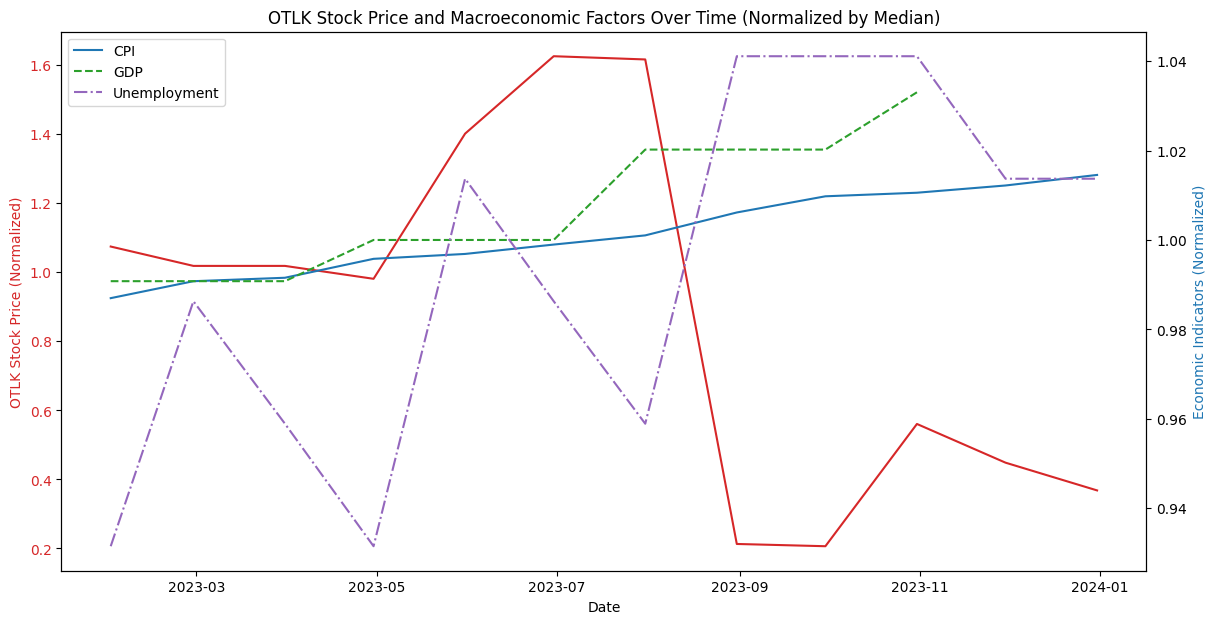

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Final Somos Classification: Sell


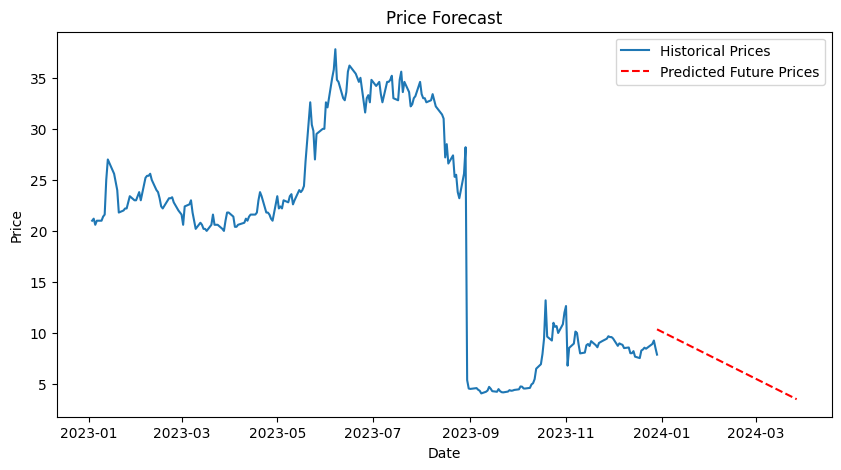

Predicted by Linear Regression Future Portfolio Value (3 months): $44549.94
Classification based on Linear Regression future portfolio value: Sell
Classification based on Significnat Price/Volume Changes : Sell


In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas_datareader.data as web

# Function to fetch stock data
def fetch_data(symbol, start_date, end_date):
    return yf.download(symbol, start=start_date, end=end_date)

# Function to generate the Somos sequence
def generate_somos_sequence(data):
    somos_sequence = []
    for i in range(3, len(data)):
        term = (data[i-1] * data[i-2] + data[i-2] * data[i-3] + data[i-3] * data[i-1]) / data[i-3]
        somos_sequence.append(term)
    return somos_sequence

# Function to calculate buy and sell ranges
def calculate_buy_sell_ranges(somos_sequence, buy_range_factor=0.85, sell_range_factor=1.10):
    somos_min = min(somos_sequence)
    somos_max = max(somos_sequence)
    buy_range = (somos_min * buy_range_factor, somos_max * buy_range_factor)
    sell_range = (somos_min * sell_range_factor, somos_max * sell_range_factor)
    return buy_range, sell_range

# Function to generate buy/sell signals based on the Somos sequence
def generate_signals(data, somos_sequence, buy_range, sell_range):
    signals = []
    holding = False
    last_buy_date, last_buy_price = None, None

    for i in range(len(somos_sequence)):
        date = data.index[i + 3]
        actual_price = data['Close'].iloc[i + 3]
        somos_price = somos_sequence[i]

        if not holding and buy_range[0] <= somos_price <= buy_range[1]:
            last_buy_price = actual_price
            last_buy_date = date
            holding = True
            signals.append(('Buy', date, actual_price))
        elif holding and sell_range[0] <= somos_price <= sell_range[1]:
            sell_price = actual_price
            sell_date = date
            holding = False
            signals.append(('Sell', sell_date, sell_price))
    
    return signals, holding, last_buy_date, last_buy_price

# Function to classify stock based on the Somos sequence portfolio value
def classify_stock_based_on_somos(portfolio_value):
    return 'Buy' if portfolio_value > 0.00 else 'Sell'

def fetch_data(symbol, start_date, end_date):
    """
    Fetch historical stock data from Yahoo Finance.
    """
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

def calculate_divergence(data, period='D'):
    """
    Calculate divergences in price and volume with specific periods (Daily, Weekly, Monthly).
    """
    if period == 'W':
        data = data.resample('W').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
    elif period == 'M':
        data = data.resample('M').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})

    data['Price Change'] = data['Close'].pct_change()
    data['Volume Change'] = data['Volume'].pct_change()
    data['Divergence Ratio Bearish'] = data['Volume Change'] / data['Price Change']
    data['Divergence Ratio Bullish'] = data['Price Change'] / data['Volume Change']
    data['Divergence Momentum Bearish'] = data['Price Change'] - data['Volume Change']
    data['Divergence Momentum Bullish'] = data['Volume Change'] - data['Price Change']

    return data

def classify_stock(data):
    """
    Classify stock based on the calculated divergence momentum.
    """
    if (data['Divergence Momentum Bullish'] > 0).mean() > 0.49:
        return 'Bullish'
    elif (data['Divergence Momentum Bearish'] > 0).mean() > 0.49:
        return 'Bearish'
    else:
        return 'Neutral'

def calculate_metrics(ticker):
    """
    Calculate fundamental financial metrics and suggest stock classification.
    """
    stock = yf.Ticker(ticker)
    income_stmt = stock.income_stmt
    cashflow = stock.cashflow
    balance_sheet = stock.balance_sheet

    last_col_index = -1
    last_5_years = income_stmt.columns[-5:]

    revenue = income_stmt.loc['Total Revenue', last_5_years].mean()
    net_income = income_stmt.loc['Net Income', last_5_years].mean()
    eps = income_stmt.loc['Diluted EPS', last_5_years].mean()
    total_debt = balance_sheet.loc['Total Debt', last_5_years].mean()
    total_equity = balance_sheet.loc['Total Equity Gross Minority Interest', last_5_years].mean()

    revenue_growth = ((revenue - income_stmt.loc['Total Revenue', income_stmt.columns[last_col_index-1]]) / income_stmt.loc['Total Revenue', income_stmt.columns[last_col_index-1]]) * 100
    profit_margin = (net_income / revenue) * 100
    debt_to_equity = total_debt / total_equity
    roe = (net_income / total_equity) * 100

    if revenue_growth > 10 and profit_margin > 10 and debt_to_equity < 1 and roe > 15:
        suggestion = "Buy"
    elif revenue_growth < 5 and profit_margin < 5 and debt_to_equity > 1.5 and roe < 10:
        suggestion = "Sell"
    else:
        suggestion = "Hold"

    return suggestion


def fetch_and_analyze_macro_data(ticker, start, end):
    """
    Fetch and analyze macroeconomic data, ensuring data alignment for comparisons.
    """
    stock_data = yf.download(ticker, start=start, end=end)
    cpi = web.DataReader('CPIAUCSL', 'fred', start, end)
    gdp = web.DataReader('GDP', 'fred', start, end)
    unemployment = web.DataReader('UNRATE', 'fred', start, end)

    # Resample data to ensure consistent frequency
    cpi_monthly = cpi['CPIAUCSL'].resample('M').ffill()
    gdp_monthly = gdp['GDP'].resample('M').ffill()
    unemployment_monthly = unemployment['UNRATE'].resample('M').ffill()
    stock_monthly = stock_data['Close'].resample('M').last()

    # Normalize the datasets using median values
    cpi_median = cpi_monthly.median()
    gdp_median = gdp_monthly.median()
    unemployment_median = unemployment_monthly.median()
    stock_median = stock_monthly.median()

    # Normalize each series to their respective medians
    cpi_normalized = cpi_monthly / cpi_median
    gdp_normalized = gdp_monthly / gdp_median
    unemployment_normalized = unemployment_monthly / unemployment_median
    stock_normalized = stock_monthly / stock_median

    # Plotting normalized data
    fig, ax1 = plt.subplots(figsize=(14, 7))
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'{ticker} Stock Price (Normalized)', color=color)
    ax1.plot(stock_normalized.index, stock_normalized, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Economic Indicators (Normalized)', color=color)
    ax2.plot(cpi_normalized.index, cpi_normalized, color=color)
    ax2.plot(gdp_normalized.index, gdp_normalized, color='tab:green', linestyle='--')
    ax2.plot(unemployment_normalized.index, unemployment_normalized, color='tab:purple', linestyle='-.')
    ax2.legend(['CPI', 'GDP', 'Unemployment'], loc='upper left')

    plt.title(f'{ticker} Stock Price and Macroeconomic Factors Over Time (Normalized by Median)')
    plt.show()

    # Analyze the relative positions of the stock price compared to the economic indicators
    if (stock_normalized < cpi_normalized).all() and (stock_normalized < gdp_normalized).all() and (stock_normalized < unemployment_normalized).all():
        return "Sell"
    elif (stock_normalized > cpi_normalized).all() and (stock_normalized > gdp_normalized).all() and (stock_normalized > unemployment_normalized).all():
        return "Buy"
    else:
        return "Hold"
def predict_future_prices(data, future_days=90):
    """
    Use linear regression to predict future stock prices.
    """
    closing_prices = data['Close']
    X = np.array(range(len(closing_prices))).reshape(-1, 1)  # Days
    y = closing_prices.values  # Prices

    model = LinearRegression().fit(X, y)
    X_future = np.array(range(len(X), len(X) + future_days)).reshape(-1, 1)
    future_prices = model.predict(X_future)

    return future_prices, closing_prices

def calculate_future_portfolio_value(closing_prices, future_prices, initial_investment=100000):
    """
    Calculate future portfolio value based on predicted prices.
    """
    current_price = closing_prices.iloc[-1]
    shares_purchased = initial_investment / current_price
    future_value = shares_purchased * future_prices[-1]
    return future_value

def fetch_and_process_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    
    # Calculate rolling mean and standard deviation for volume
    rolling_window = 20
    stock_data['Volume_Mean'] = stock_data['Volume'].rolling(window=rolling_window).mean()
    stock_data['Volume_Std'] = stock_data['Volume'].rolling(window=rolling_window).std()
    stock_data['Significant_Volume_Change'] = np.abs(stock_data['Volume'] - stock_data['Volume_Mean']) > 2 * stock_data['Volume_Std']
    
    # Calculate daily returns for price
    stock_data['Price_Returns'] = stock_data['Close'].pct_change()
    rolling_price_std = stock_data['Price_Returns'].rolling(window=rolling_window).std()
    stock_data['Significant_Price_Increase'] = stock_data['Price_Returns'] > 2 * rolling_price_std
    
    return stock_data

# Simulate trades based on volume and price triggers
def simulate_trades(stock_data):
    initial_portfolio_value = 100000
    portfolio_value = initial_portfolio_value
    cumulative_profit = 0
    trades = []
    position_open = False
    buy_date, buy_price = None, None

    significant_volume_days = stock_data[stock_data['Significant_Volume_Change']]
    significant_price_days = stock_data[stock_data['Significant_Price_Increase']]

    for i, row in stock_data.iterrows():
        if position_open:
            if i in significant_price_days.index:
                sell_date = i + pd.DateOffset(days=15)
                if sell_date in stock_data.index:
                    sell_price = stock_data.loc[sell_date, 'Open']
                    percent_change = (sell_price - buy_price) / buy_price * 100
                    cumulative_profit += percent_change
                    portfolio_value *= (1 + percent_change / 100)
                    trades.append({
                        'Buy Date': buy_date,
                        'Buy Price': round(buy_price, 2),
                        'Sell Date': sell_date,
                        'Sell Price': round(sell_price, 2),
                        '% Change': percent_change,
                        '% Cumulative Profit': cumulative_profit,
                        'Total Portfolio Value': round(portfolio_value, 0)
                    })
                    position_open = False
                    #print(f"Position closed on {sell_date} at price {sell_price}")
        else:
            if i in significant_volume_days.index:
                buy_date = i + pd.DateOffset(days=10)
                if buy_date in stock_data.index:
                    buy_price = stock_data.loc[buy_date, 'Open']
                    position_open = True
                    #print(f"Position opened on {buy_date} at price {buy_price}")

    return pd.DataFrame(trades), portfolio_value

def plot_price_forecast(closing_prices, future_prices):
    """
    Plot historical and predicted future stock prices.
    """
    future_days = len(future_prices)
    plt.figure(figsize=(10, 5))
    plt.plot(closing_prices.index, closing_prices, label='Historical Prices')
    plt.plot(closing_prices.index[-1] + pd.to_timedelta(np.arange(future_days), 'D'), future_prices, linestyle='--', color='red', label='Predicted Future Prices')
    plt.title('Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def decision_logic(weekly_classification, monthly_classification, fundamental_classification, macro_classification, somos_portfolio_value, significant_changes_portfolio_value, future_portfolio_value):
    """
    Combine weekly, monthly, fundamental, macroeconomic analyses, Somos sequence output, significant volume/price changes, 
    and future value predictions for a final decision.
    """
    decisions = []
    
    # Append decisions from classifications
    decisions.append(weekly_classification)
    decisions.append(monthly_classification)
    decisions.append(fundamental_classification)
    decisions.append(macro_classification)
    
    # Append decisions based on portfolio values
    decisions.append('Buy' if somos_portfolio_value > 100000 else 'Sell')
    decisions.append('Buy' if significant_changes_portfolio_value > 100000 else 'Sell')
    decisions.append('Buy' if future_portfolio_value > 100000 else 'Sell')
    
    # Analyzing the list of decisions to make a final call
    if decisions.count('Buy') > decisions.count('Sell'):
        return 'Buy'
    elif decisions.count('Sell') > decisions.count('Buy'):
        return 'Sell'
    else:
        return 'Hold'
    

# Example usage
symbol = 'OTLK'
start_date = '2023-01-01'
end_date = '2023-12-31'
data = fetch_data(symbol, start_date, end_date)
daily_data = calculate_divergence(data, 'D')
weekly_data = calculate_divergence(data, 'W')
monthly_data = calculate_divergence(data, 'M')
fundamental_outcome = calculate_metrics(symbol)
macro_decision = fetch_and_analyze_macro_data(symbol, start_date, end_date)
stock_classification_daily = classify_stock(daily_data)
stock_classification_weekly = classify_stock(weekly_data)
stock_classification_monthly = classify_stock(monthly_data)

# Fetch and process data
data = fetch_data(symbol, start_date, end_date)
closing_prices = data['Close'].tolist()

# Generate Somos sequence and trading ranges
somos_sequence = generate_somos_sequence(closing_prices)
buy_range, sell_range = calculate_buy_sell_ranges(somos_sequence)

# Generate trading signals
signals, holding, last_buy_date, last_buy_price = generate_signals(data, somos_sequence, buy_range, sell_range)

# Fetch and process data for trade simulation
stock_data = fetch_and_process_data(symbol, start_date, end_date)
trades_df, final_portfolio_value = simulate_trades(stock_data)

# Calculate performance metrics
drawdown = (trades_df['Total Portfolio Value'].cummax() - trades_df['Total Portfolio Value']) / trades_df['Total Portfolio Value'].cummax()
max_drawdown = drawdown.max()
returns = trades_df['% Change'] / 100
risk_free_rate = 0.0475  # Assume a risk-free rate of 4.75% annually
sharpe_ratio = (returns.mean() - risk_free_rate / 252) / returns.std() * np.sqrt(252)

# Calculate change in portfolio based on trading signals
initial_portfolio_value = 100000
current_portfolio_value = final_portfolio_value  # This should be updated based on the final value from simulate_trades
somos_portfolio_change = (current_portfolio_value - initial_portfolio_value) / initial_portfolio_value

# Classify based on Somos portfolio value
somos_classification = classify_stock_based_on_somos(somos_portfolio_change)
print("Final Somos Classification:", somos_classification)


# Classification based on Linear Regression
future_prices, closing_prices = predict_future_prices(data)
future_portfolio_value = calculate_future_portfolio_value(closing_prices, future_prices)
plot_price_forecast(closing_prices, future_prices)
classification = 'Buy' if future_portfolio_value > 100000 else 'Sell'
print(f"Predicted by Linear Regression Future Portfolio Value (3 months): ${future_portfolio_value:.2f}")
print("Classification based on Linear Regression future portfolio value:", classification)


# Classification based on final portfolio value: Significant volume and price changes
classification = 'Buy' if final_portfolio_value > 100000 else 'Sell'
print("Classification based on Significnat Price/Volume Changes :", classification)



In [25]:
# Modify the main summary table function to use the new decision logic
def create_summary_table(symbol, start_date, end_date):
    data = fetch_data(symbol, start_date, end_date)
    
    daily_data = calculate_divergence(data, 'D')
    weekly_data = calculate_divergence(data, 'W')
    monthly_data = calculate_divergence(data, 'M')
    
    macro_decision = fetch_and_analyze_macro_data(symbol, start_date, end_date)
    fundamental_outcome = calculate_metrics(symbol)
    
    closing_prices = data['Close'].tolist()
    somos_sequence = generate_somos_sequence(closing_prices)
    buy_range, sell_range = calculate_buy_sell_ranges(somos_sequence)
    signals, holding, last_buy_date, last_buy_price = generate_signals(data, somos_sequence, buy_range, sell_range)
    
    # Initial portfolio values for simulations
    initial_investment = 100000
    current_portfolio_value = simulate_somos_trading(signals, initial_investment)
    
    stock_data = fetch_and_process_data(symbol, start_date, end_date)
    trades_df, final_portfolio_value = simulate_trades(stock_data)
    
    future_prices, closing_prices = predict_future_prices(data)
    future_portfolio_value = calculate_future_portfolio_value(closing_prices, future_prices)
    
    final_decision = decision_logic(
        classify_stock(weekly_data), 
        classify_stock(monthly_data), 
        fundamental_outcome, 
        macro_decision, 
        current_portfolio_value, 
        final_portfolio_value, 
        future_portfolio_value
    )
    
    summary_data = {
        'Ticker Symbol': symbol,
        'Start Date': start_date,
        'End Date': end_date,
        'Daily Divergence': daily_data['Divergence Momentum Bullish'].iloc[-1],
        'Weekly Divergence': weekly_data['Divergence Momentum Bullish'].iloc[-1],
        'Monthly Divergence': monthly_data['Divergence Momentum Bullish'].iloc[-1],
        'Macro Decision': macro_decision,
        'Fundamental Analysis': fundamental_outcome,
        'Somos Sequence Output': current_portfolio_value,
        'Significant Volume & Price Changes': final_portfolio_value,
        'Linear Regression Future Value': future_portfolio_value,
        'Review of All Factors': final_decision,
        'Final Recommendation': final_decision
    }
    
    summary_table = pd.DataFrame([summary_data])
    return summary_table

In [26]:
summary_table

,Ticker Symbol,Start Date,End Date,Daily Divergence,Weekly Divergence,Monthly Divergence,Macro Decision,Fundamental Analysis,Somos Sequence Output,Significant Volume & Price Changes,Linear Regression Future Value,Review of All Factors,Final Recommendation
0,OTLK,2023-01-01,2023-12-31,-0.396448,0.96411,-0.551802,Hold,Hold,79842.42683,79842.42683,44549.938132,Hold,Hold
